<a href="https://colab.research.google.com/github/SwarajShinde/Text-Classfication-BOW------BERT/blob/main/GIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
train = pd.read_json("/content/drive/My Drive/machine_hack/train_clean.json")
test = pd.read_json("/content/drive/My Drive/machine_hack/test_clean.json")

In [90]:
from sklearn.metrics import accuracy_score
import torch
from tqdm.notebook import tqdm

In [91]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [92]:
!pip install transformers
import transformers
from transformers import AdamW


# EDA

In [93]:
# finding out the max len
temp_train = train[:1000]

In [94]:
temp_train.head(4)

,label,title,body
0,1,y-zoom piano roll,y-zoom piano roll would useful.
1,0,buggy behavior selection,! screenshot 2016-02-23 21 27 40 https://cloud...
2,1,auto update feature,"hi,\r \r great job far, @saenzramiro ! : \r \r..."
3,1,filter noisy endpoints logs,think stop logging requests to:\r - __health \...


In [153]:
se = 'I love india '


In [154]:
tep =  [se.split(" ")]
import nltk
nltk.download('punkt')
toki = nltk.word_tokenize(se)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
len(toki)

3

In [98]:
def toke(sent):
    opo = nltk.word_tokenize(sent)
    return len(opo)
temp_train['num_tok_title'] = temp_train['title'].apply(lambda x:toke(x) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [99]:
temp_train['num_tok_Body'] = temp_train['body'].apply(lambda x:toke(x) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [100]:
temp_train.head(5)

,label,title,body,num_tok_title,num_tok_Body
0,1,y-zoom piano roll,y-zoom piano roll would useful.,3,6
1,0,buggy behavior selection,! screenshot 2016-02-23 21 27 40 https://cloud...,3,10
2,1,auto update feature,"hi,\r \r great job far, @saenzramiro ! : \r \r...",3,28
3,1,filter noisy endpoints logs,think stop logging requests to:\r - __health \...,4,16
4,0,enable pid / pid alarm actions arduino/tc4,expected behavior\r alarm actions pid pid enab...,7,245


In [156]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
def remove_stop(sent):
    fins = [i for i in nltk.word_tokenize(sent) if i not in stop]
    return " ".join(fins)

In [105]:
temp_train['stop_title'] = temp_train['title'].apply(lambda x:remove_stop(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:

temp_train['stop_body'] = temp_train['body'].apply(lambda x:remove_stop(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
temp_train['num_stop_Body'] = temp_train['body'].apply(lambda x:toke(x) )
temp_train['num_stop_title'] = temp_train['title'].apply(lambda x:toke(x) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


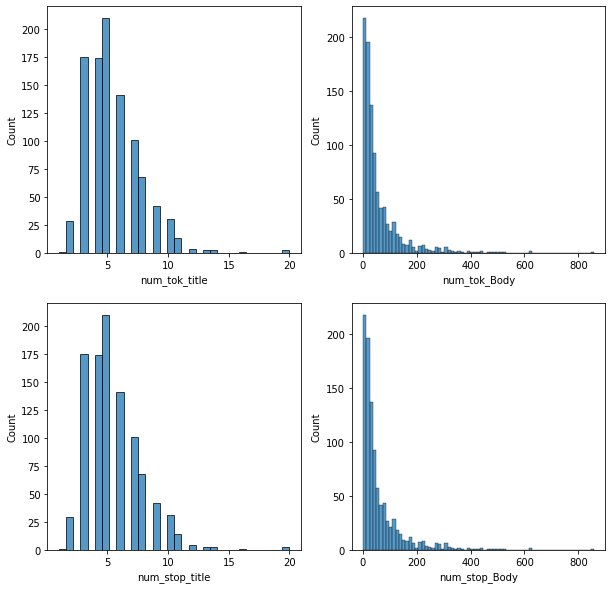

In [108]:
fig,axes = plt.subplots(figsize=(10,10),nrows=2,ncols=2)
sns.histplot(temp_train['num_tok_title'],ax=axes[0][0])
sns.histplot(temp_train['num_tok_Body'],ax=axes[0][1])
sns.histplot(temp_train['num_stop_title'],ax=axes[1][0])
sns.histplot(temp_train['num_stop_Body'],ax=axes[1][1])

In [109]:
dict_ = {0:'Bug',1:'Feature',2:'Question'}

In [110]:
def show(df,randomization,num_entry,lbl,col,lbl_val):
    size = df.shape
    nums = size[0]   
    for i in range(num_entry):
        if randomization : 
            num_ = random.randint(0,nums-1) 
        else: num_ = i
        print(df[col][num_])
        print(f"Label : {lbl_val[df[lbl][num_]]}")


In [123]:
show(temp_train,randomization=True,num_entry=4,lbl='label',col='stop_body',lbl_val=dict_)

starting point : v2.html\r link : https : //naturalintelligence.github.io/imglab/v2.html\r \r top right side 3 buttons : plugins , keyboard , donate . browser window < 1412px . properly aligned . \r \r elements menu aligned different screen size .
Label : Bug
seems unit tests trying pull wrong module somehow ? seem thing pulls directly qunit . \r \r import { module , test } 'qunit ' ; \r \r generated running ember g util foo \r \r perhaps need fix blueprint pull module differently ? unsure.\r \r error : \r \r stack : > \r http : //localhost:7357/assets/test-support.js:7092\r message : > \r error : \r error : global module removed qunit 2.0.\r details upgrade guide https : //qunitjs.com/upgrade-guide-2.x/\r
Label : Bug
stick gh pages , 'll need work around data collection . one possible solution https : //coderwall.com/p/8lq1ba
Label : Feature
invalid_function autocompletion , 's example : \r ! valivnzlqu https : //user-images.githubusercontent.com/31375974/48679831-d88c3a80-eba5-11e8-9

In [161]:
# most frequent words:
from collections import Counter
cnt = Counter()
for txt in temp_train['body'].values:
    for word in txt.split():
        cnt[word] += 1
cnt.most_common(10)

[('r', 4675),
 ('file', 227),
 ('error', 210),
 ('1', 196),
 ('version', 185),
 ('would', 181),
 ('use', 163),
 ('new', 150),
 ('like', 142),
 ('add', 140)]

In [176]:
# least freq words
# single words chars
# digits 
count = 0
uniq_words = set()
for i in cnt:
    if cnt[i]==1:
        count+=1
        uniq_words.add(i)
print(len(uniq_words))
print(count)

7612
7612


In [177]:
def aggresive(x):
    fins = [i for i in nltk.word_tokenize(x) if i not in uniq_words]
    return " ".join(fins)



In [ ]:
temp_train['least_Freq'] = temp_train['body'].apply(lambda x: aggresive(x))

In [188]:
temp_train['agg_num_tok_body'] = temp_train['least_Freq'].apply(lambda x:toke(x) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


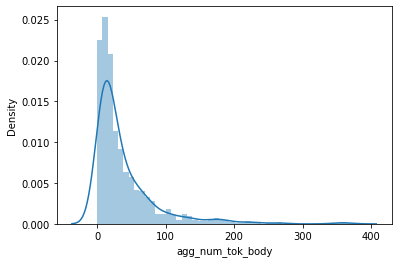

In [189]:
sns.distplot(temp_train['agg_num_tok_body'])

In [183]:
fin_tits = Counter()
for i in temp_train['title']:
    for j in i.split():
        fin_tits[j]+=1
fin_tit = set()
for m in fin_tits:
    if fin_tits[m] == 1:
        fin_tit.add(m)



In [186]:
def aggresive_title(x):
    fins = [i for i in nltk.word_tokenize(x) if i in fin_tit] 
    return " ".join(fins)

In [192]:
# lets do the same for title
# not a good idea for title 
temp_train['agg_title'] = temp_train['title'].apply(lambda x: aggresive_title(x))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


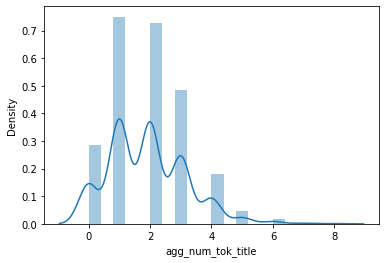

In [190]:
temp_train['agg_num_tok_title'] = temp_train['agg_title'].apply(lambda x: toke(x))
sns.distplot(temp_train['agg_num_tok_title'])

In [191]:
temp_train

,label,title,body,num_tok_title,num_tok_Body,stop_title,stop_body,num_stop_Body,num_stop_title,num_tok_body,least_Freq,agg_num_tok_body,agg_title,agg_num_tok_title
0,1,yzoom piano roll,yzoom piano roll would useful,3,6,y-zoom piano roll,y-zoom piano roll would useful .,6,3,5,roll would useful,3,yzoom piano roll,3
1,0,buggy behavior selection,screenshot 20160223 21 27 40 httpscloudgithub...,3,10,buggy behavior selection,! screenshot 2016-02-23 21 27 40 https : //clo...,10,3,7,screenshot 21 27 40 r,5,buggy behavior,2
2,1,auto update feature,hir r great job far saenzramiro r r auto upd...,3,28,auto update feature,"hi , \r \r great job far , @ saenzramiro ! : \...",28,3,21,hir r great job far r r auto update feature wo...,20,,0
3,1,filter noisy endpoints logs,think stop logging requests tor health r gtg...,4,16,filter noisy endpoints logs,think stop logging requests : \r - __health \r...,16,4,11,think stop logging requests tor health r r r,9,noisy endpoints,2
4,0,enable pid pid alarm actions arduinotc4,expected behaviorr alarm actions pid pid enabl...,6,245,enable pid / pid alarm actions arduino/tc4,expected behavior\r alarm actions pid pid enab...,245,7,198,expected behaviorr alarm actions pid pid enabl...,175,alarm arduinotc4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,problem fetching images,dynamically loading cities label position some...,3,31,problem fetching images,dynamically loading cities label position some...,31,3,25,dynamically loading cities label position some...,23,fetching,1
996,1,climb vines ceiling,climb vines ceiling see httpswwwredditcomrmine...,3,10,climb vines ceiling,"climb vines ceiling , see https : //www.reddit...",10,3,6,see command,2,climb vines ceiling,3
997,0,player disappears boss chunks,end game kill boss boss explode leaving little...,4,56,player disappears boss chunks,"end game , kill boss , boss explode leaving li...",56,4,47,end game kill boss boss explode leaving little...,43,disappears,1
998,1,improves regexp routes,try implement next regexpr r w r r r...,3,55,improves regexp routes,try implement next regexp\r \r ^\\/\\^\\\\\\/ ...,55,3,25,try implement next r w r r r next type r ir r ...,16,improves routes,2


In [118]:
import string
Punct = string.punctuation
puncts = set(Punct)
def remove_punct(x):
    return x.translate(x.maketrans('','',Punct))

In [ ]:
temp_train['title'] = temp_train['title'].apply(lambda x : remove_punct(x))
temp_train['body'] = temp_train['body'].apply(lambda x : remove_punct(x))

In [ ]:
temp_train['num_tok_title'] = temp_train['title'].apply(lambda x:toke(x) )
temp_train['num_tok_body'] = temp_train['body'].apply(lambda x:toke(x) )

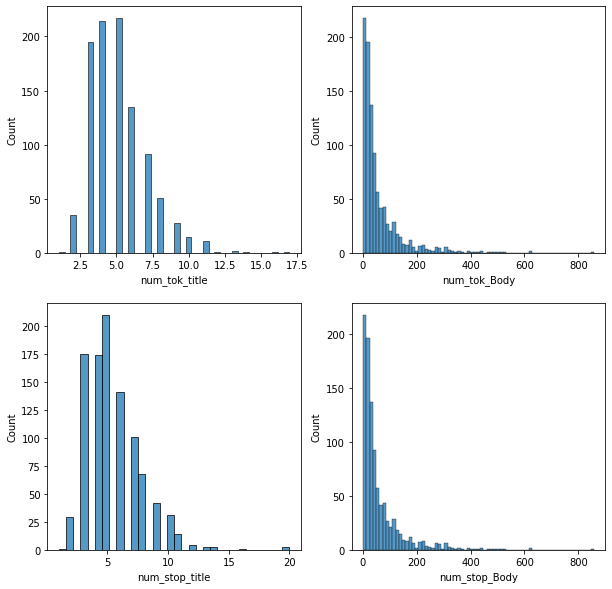

In [121]:
fig,axes = plt.subplots(figsize=(10,10),nrows=2,ncols=2)
sns.histplot(temp_train['num_tok_title'],ax=axes[0][0])
sns.histplot(temp_train['num_tok_Body'],ax=axes[0][1])
sns.histplot(temp_train['num_stop_title'],ax=axes[1][0])
sns.histplot(temp_train['num_stop_Body'],ax=axes[1][1])

In [122]:
temp_train.head()

,label,title,body,num_tok_title,num_tok_Body,stop_title,stop_body,num_stop_Body,num_stop_title,num_tok_body
0,1,yzoom piano roll,yzoom piano roll would useful,3,6,y-zoom piano roll,y-zoom piano roll would useful .,6,3,5
1,0,buggy behavior selection,screenshot 20160223 21 27 40 httpscloudgithub...,3,10,buggy behavior selection,! screenshot 2016-02-23 21 27 40 https : //clo...,10,3,7
2,1,auto update feature,hir r great job far saenzramiro r r auto upd...,3,28,auto update feature,"hi , \r \r great job far , @ saenzramiro ! : \...",28,3,21
3,1,filter noisy endpoints logs,think stop logging requests tor health r gtg...,4,16,filter noisy endpoints logs,think stop logging requests : \r - __health \r...,16,4,11
4,0,enable pid pid alarm actions arduinotc4,expected behaviorr alarm actions pid pid enabl...,6,245,enable pid / pid alarm actions arduino/tc4,expected behavior\r alarm actions pid pid enab...,245,7,198


In [139]:
temp_train_grp = temp_train.groupby(by="num_stop_Body").min()

In [152]:
temp_train[temp_train['num_tok_Body'] == 857]['body'].values

array(['tried using winject chaoslauncher chaoslauncher runs wmode fine following error occurs running bwapir r  screenshot 20150713 10 18 03 httpscloudgithubusercontentcomassets1966366865171496e49320294811e585374bac5f0091aepng r r original issue posted florian richoux facebook group httpswwwfacebookcomgroupsbwapi  recent issue appeared bwapi updated use visual c 2013r r relevant error message isr r errmoduleimportdll loading library msvcp120dll needed l cprogram files x86 starcraftbwapidatabwapidll failed error c000007b r r r full logr r 1927254510016tracemoduleloaddll looking l msvcp120dll l cprogram files x86 starcraftcwindowssystem32cwindowssystemcwindowscwindowssystem32cwindowscwindowssystem32wbem r 1927254510016traceactctxrtlfindactivationcontextsectionstring 00000001 null 2 l msvcp120dll 0x34f430r 1927254510016traceheaprtlallocateheap 0x110000700000620000005c  returning 0x12f648r 1927254510016tracefilertldospathnametontpathnameu l cprogram files x86 starcraftmsvcp120dll 0x34f2e8

In [ ]:
# lets remove 'single char' words
# https remove 
# del numbers 



# Pytorch Implementation

In [ ]:
class CONFIG:
    DEVICE = 'cuda'
    bert_path = 'bert-base-uncased'
    tokenizer = transformers.BertTokenizer.from_pretrained(bert_path, do_lower_case=True)
    MAX_LEN = 125
    train_batch_size = 8
    valid_batch_size = 8
    model_path = '/content/'
    epochs = 5
    num_folds = 5



In [ ]:
class Train_dataset(Dataset):
    def __init__(self,title,label,max_len):
        self.title = title
        self.label = label
        self.max_len = CONFIG.MAX_LEN
        self.tokenizer = CONFIG.tokenizer
    def __len__(self):
        return len(self.title)
    def __getitem__(self,idx):
        review = str(self.title[idx])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length = self.max_len,
            padding = 'max_length'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        targets = self.label[idx]
        return {
            "ids":torch.tensor(ids,dtype=torch.long),
            "mask":torch.tensor(mask,dtype=torch.long),
            "token_type_ids":torch.tensor(token_type_ids,dtype=torch.long),
            "targets":torch.tensor(targets,dtype=torch.float)
        }


In [ ]:
class Test_dataset(Dataset):
    def __init__(self,title,max_len):
        self.title = title
        self.max_len = CONFIG.MAX_LEN
        self.tokenizer = CONFIG.tokenizer
    def __len__(self):
        return len(self.title)
    def __getitem__(self,idx):
        review = str(self.title[idx])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length = self.max_len,
            padding = 'max_length'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        return {
            "ids":torch.tensor(ids,dtype=torch.long),
            "mask":torch.tensor(mask,dtype=torch.long),
            "token_type_ids":torch.tensor(token_type_ids,dtype=torch.long),
        }


In [ ]:
def loss_fn(outputs,targets):
    return nn.CrossEntropyLoss()(outputs,targets)

In [ ]:
def train_fn(model,train_loader,optimizer,device):
    model.train()
    tk0 = tqdm(train_loader,total = len(train_loader))
    for n,data in enumerate(tk0):
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets'] 
        ids = ids.to(device,dtype=torch.long)
        mask = mask.to(device,dtype=torch.long)
        token_type_ids = token_type_ids.to(device,dtype=torch.long)
        targets = targets.to(device,dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
        loss = loss_fn(outputs,targets)
        #print(f'Training loss {loss.item()} training Batch {n}')
        loss.backward()
        optimizer.step()
        model.zero_grad()


In [ ]:
def eval_fn(model,eval_loader,optimizer,device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    tk0 = tqdm(eval_loader,total = len(eval_loader))
    with torch.no_grad():        
        for id,data in enumerate(tk0):
            ids = data['ids']
            mask = data['mask']
            token_type_ids = data['token_type_ids']
            targets = data['targets'] 
            ids = ids.to(device,dtype=torch.long)
            mask = mask.to(device,dtype=torch.long)
            token_type_ids = token_type_ids.to(device,dtype=torch.long)
            targets = targets.to(device,dtype=torch.long)
            outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
            loss = loss_fn(outputs,targets)
            sig_op = torch.argmax(torch.sigmoid(outputs),axis=1)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(sig_op.cpu().detach().numpy().tolist())
            #print(f'Valdition Loss {loss.item()} Val Accuracy :')
    return fin_outputs,fin_targets

In [ ]:
def test_fn(model,test_loader,optimizer,device):
    model.eval()
    pred_targets = []
    pred_outputs = []
    tk0 = tqdm(test_loader,total = len(test_loader))
    with torch.no_grad():        
        for id,data in enumerate(tk0):
            ids = data['ids']
            mask = data['mask']
            token_type_ids = data['token_type_ids']
            ids = ids.to(device,dtype=torch.long)
            mask = mask.to(device,dtype=torch.long)
            token_type_ids = token_type_ids.to(device,dtype=torch.long)
            outputs = model(ids=ids,mask=mask,token_type_ids=token_type_ids)
            sig_op = torch.argmax(torch.sigmoid(outputs),axis=1)
            pred_outputs.extend(sig_op.cpu().detach().numpy().tolist())
            #print(f'Valdition Loss {loss.item()} Val Accuracy :')
    return pred_outputs

    # make some changes ie save the argmax of o/p , not only the sigmoids

In [ ]:
class BertModel(nn.Module):
    def __init__(self):
        super(BertModel,self).__init__()
        self.bert = transformers.BertModel.from_pretrained(CONFIG.bert_path)
        self.drop = nn.Dropout(0.2)
        self.out = nn.Linear(768,3)
    def forward(self,ids,mask,token_type_ids):
        _,op = self.bert(ids,attention_mask = mask,token_type_ids = token_type_ids)
        x = self.drop(op)
        output = self.out(x)
        return output


In [ ]:
train['kfold']  =-1
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
train = train.sample(frac=1).reset_index(drop=True)
y=train['label'].values
for n,(t_idx,val_idx) in enumerate(skf.split(X=train,y=y)):
    train.loc[val_idx,'kfold'] = n
train['kfold'].value_counts()

4    30000
3    30000
2    30000
1    30000
0    30000
Name: kfold, dtype: int64

In [ ]:
def run_single_fold(train,test,fold_num,device):
    train = train.fillna("none")
    train_df = train[train['kfold']!=fold_num]
    valid_df = train[train['kfold']==fold_num]
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    print(f"train dataframe shape {train_df.shape}")
    print(f"train dataframe shape {valid_df.shape}")
    train_ds = Train_dataset(train_df['title'][:5000],train_df['label'][:5000],max_len=CONFIG.MAX_LEN)
    valid_ds = Train_dataset(valid_df['title'][:5000],valid_df['label'][:5000],max_len=CONFIG.MAX_LEN)
    train_loader = DataLoader(train_ds,batch_size=CONFIG.train_batch_size,num_workers=2,shuffle=True)
    valid_loader = DataLoader(valid_ds,batch_size=CONFIG.valid_batch_size,num_workers=2,shuffle=False)
    device = torch.device(CONFIG.DEVICE)
    model = BertModel()
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=3e-5,correct_bias=False)
    best_accuracy = 0
    for epoch in range(CONFIG.epochs):
        train_fn(model=model,train_loader=train_loader,optimizer=optimizer,device=device)
        outputs,targets = eval_fn(model,valid_loader,optimizer,device=device)
        accuracy = accuracy_score(outputs,targets)
        print(outputs)
        print(targets)
        print(f"Accuracy Score {accuracy} Epoch {epoch}")
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(),f"fold{fold_num}_seed{epoch}_train9.pth")

            # 5 fold training ; generate csv files for each , on a sample of data


In [ ]:
run_single_fold(train,test,fold_num=2,device=CONFIG.DEVICE)

KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi
#killall python



In [ ]:
import torch, gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
clear_cache()

In [ ]:
tmp = torch.rand((8,3))

In [ ]:
test.shape


In [ ]:
# lets test this stuff on test_data:
test_ds = Test_dataset(test['title'],max_len=CONFIG.MAX_LEN)
test_dl = DataLoader(test_ds,batch_size=CONFIG.valid_batch_size,shuffle=False,num_workers=2)


In [ ]:
model = BertModel()
device = torch.device(CONFIG.DEVICE)
model.to(device)



In [ ]:
model.load_state_dict(torch.load("/content/fold1_seed1_train9.pth"))
model.eval()
model.to(device)

In [ ]:
prediction = test_fn(model=model,test_loader=test_dl,optimizer=optimizer,device=CONFIG.DEVICE)

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-5,correct_bias=False)


In [ ]:
len(prediction)

In [ ]:
test_temp = test[:4000]


In [ ]:
test_temp['label2'] = prediction

In [ ]:
test_temp.to_csv('prediction_1_seed1_train2.csv',index=False)

In [ ]:
df_pred_1 = pd.read_csv("/content/prediction_1_seed1_train4.csv")

In [ ]:
test_temp['label'].value_counts()

In [ ]:
test_temp['label2'].value_counts()

In [ ]:
test_temp.to_csv("test_temp",index=False)

In [ ]:
iilo = pd.read_csv("/content/test_temp")

In [ ]:
fig,ax = plt.subplots(1,2)
sns.countplot(iilo['label'],ax=ax[0])
sns.countplot(iilo['label2'],ax=ax[1])

In [ ]:
submission_df = pd.DataFrame(prediction,columns=['label'])

In [ ]:
submission_df.to_csv('20k_1_sub.csv',index=False)

In [ ]:
print('jeck')

In [ ]:
len('jack is a bitch')

In [ ]:
token_lens